In [ ]:
!pip install image-classifiers

In [1]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = pathlib.Path('../data/posters/')

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
CLASS_NAMES = np.array(['Action', 'Animation', 'Comédie', 'Comédie-dramatique', 'Documentaire', 'Drame', 'Thriller-Policier'])

In [3]:
from classification_models.tfkeras import Classifiers
# from tensorflow.keras.applications.resnet_v2 import preprocess_input

ResNet18, preprocess_input = Classifiers.get('resnet18')

image_generator ={
    'train': tf.keras.preprocessing.image.ImageDataGenerator(
#                                                     rescale=1./255,  # pas avec preprocess_input
#                                                     rotation_range=30,
#                                                     width_shift_range=.15,
#                                                     height_shift_range=.15,
                                                    horizontal_flip=True,
#                                                     brightness_range=(0.5, 1),
#                                                     zoom_range=0.5,
                                                    preprocessing_function=preprocess_input
                                                    ),
    'val': tf.keras.preprocessing.image.ImageDataGenerator(
#                                             rescale=1./255, 
                                            preprocessing_function=preprocess_input
                                            ),
    'test': tf.keras.preprocessing.image.ImageDataGenerator(
#                                             rescale=1./255, 
                                            preprocessing_function=preprocess_input
                                            ),
}

dataset = {x: image_generator[x].flow_from_directory(directory=str(data_dir/x),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     interpolation='bilinear')
           for x in ['train', 'val', 'test']
}

Found 3430 images belonging to 7 classes.
Found 735 images belonging to 7 classes.
Found 735 images belonging to 7 classes.


In [4]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img/255)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n]/255)
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

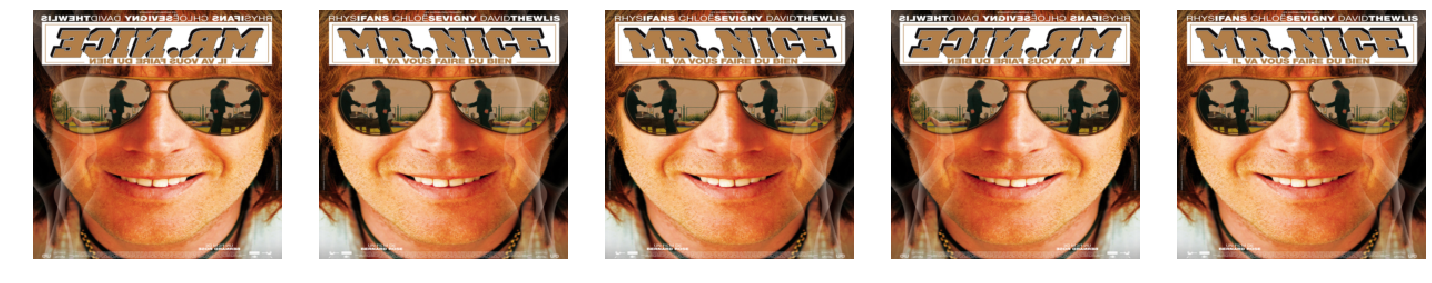

In [5]:
augmented_images = [dataset['train'][0][0][0] for i in range(5)]
plotImages(augmented_images)

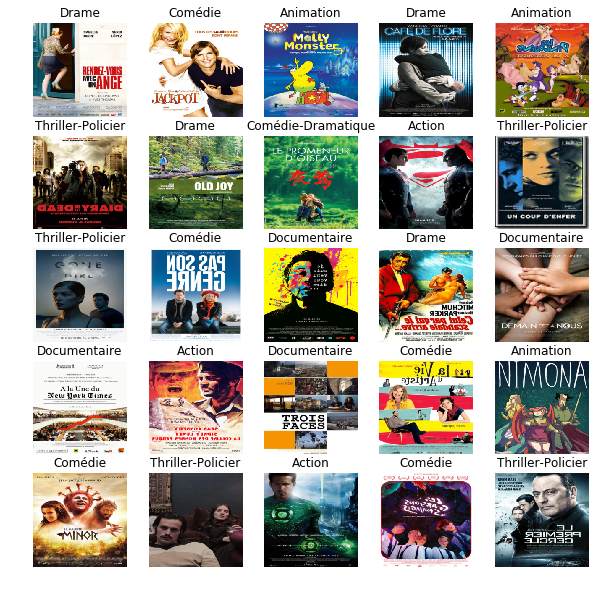

In [6]:
image_batch, label_batch = next(dataset['train'])
show_batch(image_batch, label_batch)

In [7]:
# base_model = tf.keras.applications.resnet_v2.ResNet50V2(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
#                                                include_top=False,
#                                                weights='imagenet')
base_model = ResNet18((IMG_WIDTH, IMG_HEIGHT, 3), include_top=False, weights='imagenet')
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(7, activation="softmax")

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [9]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
# model.load_weights('./resnet18_10e_freeze')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         11186889  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3591      
Total params: 11,190,480
Trainable params: 3,591
Non-trainable params: 11,186,889
_________________________________________________________________


In [11]:
checkpoint_path = '../data/checkpoints/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [12]:
initial_epochs = 10

history = model.fit(dataset['train'],
                    epochs=initial_epochs,
                    validation_data=dataset['val'],
                    callbacks=[cp_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 108 steps, validate for 23 steps
Epoch 1/10
107/108 [============================>.] - ETA: 0s - loss: 1.9081 - accuracy: 0.2295
Epoch 00001: saving model to ../data/checkpoints/
108/108 [==============================] - 125s 1s/step - loss: 1.9084 - accuracy: 0.2297 - val_loss: 1.8675 - val_accuracy: 0.2871
Epoch 2/10
107/108 [============================>.] - ETA: 0s - loss: 1.8319 - accuracy: 0.3334
Epoch 00002: saving model to ../data/checkpoints/
108/108 [==============================] - 123s 1s/step - loss: 1.8323 - accuracy: 0.3327 - val_loss: 1.7713 - val_accuracy: 0.4082
Epoch 3/10
107/108 [============================>.] - ETA: 0s - loss: 1.7493 - accuracy: 0.4303
Epoch 00003: saving model to ../data/checkpoints/
108/108 [==============================] - 123s 1s/step - loss: 1.7498 - accuracy: 0.4297 - val_loss: 1.7402 - val_accuracy: 0.4340
Epoch 4/10
107/108 [============================>.] - ETA: 0s - loss: 1.7

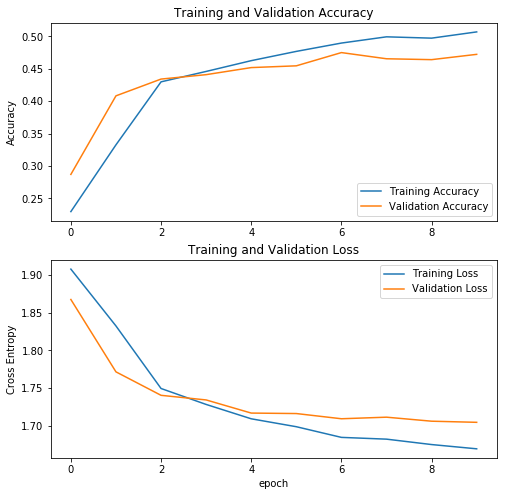

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('traing2311.png')
plt.show()

In [14]:
loss0,accuracy0 = model.evaluate(dataset['test'])

  ...
    to  
  ['...']
23/23 [==============================] - 22s 936ms/step - loss: 1.7265 - accuracy: 0.4313


In [15]:
checkpoint_path = '../data/checkpoints/cp.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
fine_tune_epochs = 10
nb = 5
learning_rate = base_learning_rate
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
history_fine = history


for turn in range(1, nb+1):
    base_model.trainable = True
    fine_tune_at = max(0,86-turn*86//nb)
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False
    
    learning_rate /= 10
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    total_epochs =  initial_epochs + fine_tune_epochs

    history_fine = model.fit(dataset['train'],
                             epochs=total_epochs,
                             initial_epoch = history_fine.epoch[-1],
                             validation_data=dataset['val'],
                             callbacks=[cp_callback])
    initial_epochs = total_epochs
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']

    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 108 steps, validate for 23 steps
Epoch 10/20
107/108 [============================>.] - ETA: 1s - loss: 1.6933 - accuracy: 0.4738
Epoch 00010: saving model to ../data/checkpoints/cp.ckpt
108/108 [==============================] - 133s 1s/step - loss: 1.6929 - accuracy: 0.4743 - val_loss: 1.6984 - val_accuracy: 0.4517
Epoch 11/20
107/108 [============================>.] - ETA: 1s - loss: 1.5557 - accuracy: 0.6115
Epoch 00011: saving model to ../data/checkpoints/cp.ckpt
108/108 [==============================] - 132s 1s/step - loss: 1.5555 - accuracy: 0.6117 - val_loss: 1.7040 - val_accuracy: 0.4476
Epoch 12/20
107/108 [============================>.] - ETA: 1s - loss: 1.4755 - accuracy: 0.7019
Epoch 00012: saving model to ../data/checkpoints/cp.ckpt
108/108 [==============================] - 132s 1s/step - loss: 1.4769 - accuracy: 0.7003 - val_loss: 1.7008 - val_accuracy: 0.4327
Epoch 13/20
 12/108 [==>.........................

KeyboardInterrupt: 

In [23]:
# model.save_weights('./resnet18_fine_2')

In [24]:
loss1, accuracy1 = model.evaluate(dataset['test'])

  ...
    to  
  ['...']
23/23 [==============================] - 21s 930ms/step - loss: 1.7225 - accuracy: 0.4259


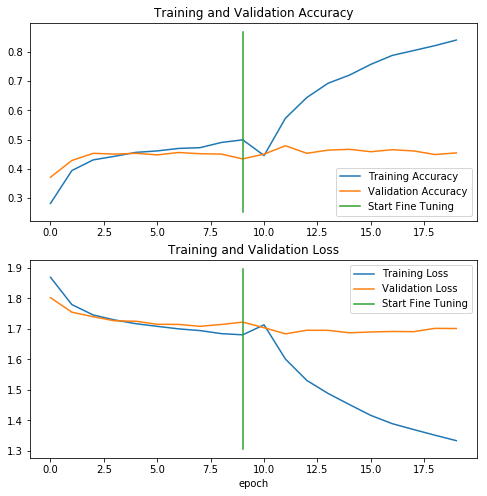

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('training2.png')
plt.show()

In [28]:
print(accuracy0, accuracy1)

0.414966 0.42585033
